---

# 4 Getting started with neural networks:

# Classification and regression

In [1]:
import os
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 3  # nice scatter point size

from IPython.display import clear_output
from IPython.display import YouTubeVideo

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # mute some annoying warnings

#### Binary classification: data → scalar (probability of *one* class)

*\"Here is a photo, is it a cat or not?" (Negative/Positive, detecting if something is there, etc.)*

## * Multiclass classification: data → vector (distribution over *many classes*)

*\"Here is a photo, multiple choice for you: is it a cat, a dog, an airplane, a flower, ... ?*

#### Regression: data → scalar (a continuous value describing the data)

*\"Here is a data about a house, what is its price)?* <small>☠️☠️☠️ *Logistic regression* (*classification problem*) ≠ *regression*!!</small>

---

# 4.2 Classifying newswires: A multiclass classification example

### 4.2.1 The Reuters dataset

The reviews in the IMDB were either positive or negative.

Single-label, two classes.

Other classification tasks:
 - single-label, multiclass;
 - multi-label, multiclass.

Each newswire (short textual reports) in the Reuters dataset fits into **one of 46 possible classes**.

 - **single-label, multiclass;**
 - multi-label, multiclass.

### Code: loading the dataset

In [2]:
(train_data, train_labels,), (test_data, test_labels) = tf.keras.datasets.reuters.load_data(num_words=10000)
print(train_data.shape, test_data.shape)

(8982,) (2246,)


In [3]:
def decode_wire(wire):
    """A helper function to decode a wire."""
    word_index = tf.keras.datasets.reuters.get_word_index()
    reverse_word_index = {value:key for key,value in word_index.items()}
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in wire])
    return decoded_review

In [4]:
# https://github.com/keras-team/keras/issues/12072
# and here: https://martin-thoma.com/nlp-reuters/
topics = [
    'cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
    'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
    'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
    'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
    'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead'
]

#### Check one text

In [8]:
print(decode_wire(test_data[0]))
print()
print('topic: ', topics[test_labels[0]])

? the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to ? growth and expansion plans for ? inc and ? inc over the next two years a and p said the acquisition of ? in august 1986 and ? in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt ? ? of west germany reuter 3

topic:  earn


---

## 4.2.2 Preparing the data

Data preprocessing follows the IMDB example.

The sequences are **multi-hot** encoded, like before.

The labels are also one-hot/categorically encoded.

#### Code: encode the samples

In [5]:
def vectorize_sequences(sequences, dimension = 10000):
    results = np.zeros((len(sequences), dimension))       # create an empty matrix of zeros
    for i, sequence in enumerate(sequences):              # for each sequence
        results[i, sequence] = 1.                         # at the `indices` of our words, add a 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [6]:
print(f"sequence length: {len(train_data[0])}")
print(train_data[0])
print()
print(f"sequence length: {len(x_train[0])}")
print(x_train[0]) # index = word, '1' means: the word was present (note: all order is dropped!)

sequence length: 87
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]

sequence length: 10000
[0. 1. 1. ... 0. 0. 0.]


#### Code: encode the labels

In [7]:
# one hot encoder for our labels
one_hot_train_labels = tf.keras.utils.to_categorical(train_labels)
one_hot_test_labels = tf.keras.utils.to_categorical(test_labels)

In [8]:
print(f"number of classes: {one_hot_train_labels.shape[1]}")
print()
print(f"label: {train_labels[0]}")
print()
print("one hot:")
print(one_hot_train_labels[0])

number of classes: 46

label: 3

one hot:
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


---

## 4.2.3 Building your model

### Our problem

With 46 classes, the classification problem is more complex than the two class IMDB example.

We used a 16 dimensional representational space for the intermediate IMDB layers.

But 16 dimensions might be too small.

Information dropped by a layer can never be recovered – a potential **information bottleneck**.

Therefore we need bigger layers (more units).

Let's try 64 unit layers.

### Loss & Final Layer

We require that the network outputs a 46D vector; therefore the final layer must have 46 units.

The layer should output the **probability of class membership**.

For that we use our old friend the **softmax**.

#### Softmax

The math, in case...

$$
\bbox[5px,border:2px solid red]
{
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_i e^{x_i}}
}
$$

I0000 00:00:1729068543.012762 12470967 service.cc:146] XLA service 0x600001b04500 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729068543.013546 12470967 service.cc:154]   StreamExecutor device (0): Host, Default Version


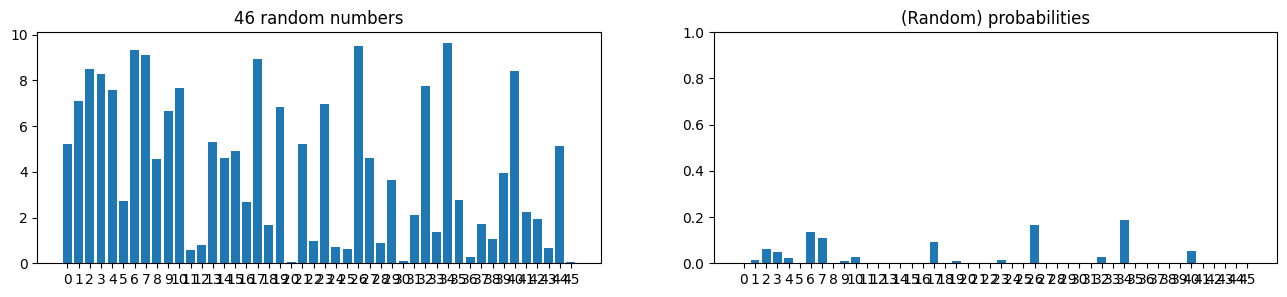

In [13]:
nums = tf.random.uniform(shape=(46,)) * 10              # 46 random numbers
probs = tf.nn.softmax(nums)                             # turned into probabilities

fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, figsize=(16,3))
ax1.bar([str(x) for x in range(nums.shape[0])], nums)   # our ten numbers
ax1.set_title("46 random numbers")
ax2.bar([str(x) for x in range(probs.shape[0])], probs) # plot the probabilities
ax2.set_title("(Random) probabilities")
ax2.set_ylim([0,1])
plt.show()

#### Categorical Cross-Entropy

What does the categorical cross-entropy loss do?

$$
\bbox[5px,border:2px solid red]
{
H(p,q)=-\sum _{x}p(x)\,\log q(x)
}
$$

$H$: relative entropy, what we're actually measuring  
$p$: true probability (our labels)  
$q$: model probability (our guesses)

- the ground truth will be multiplied with our probabilities
- all terms except the correct class (label 1) become zero
- the last remaining term is just $ - \log(q(x_{true})) = - \log(guessed\ probability\ of\ true\ label)$

See Aurélien Géron's video on Cross-Entropy is in the reference!

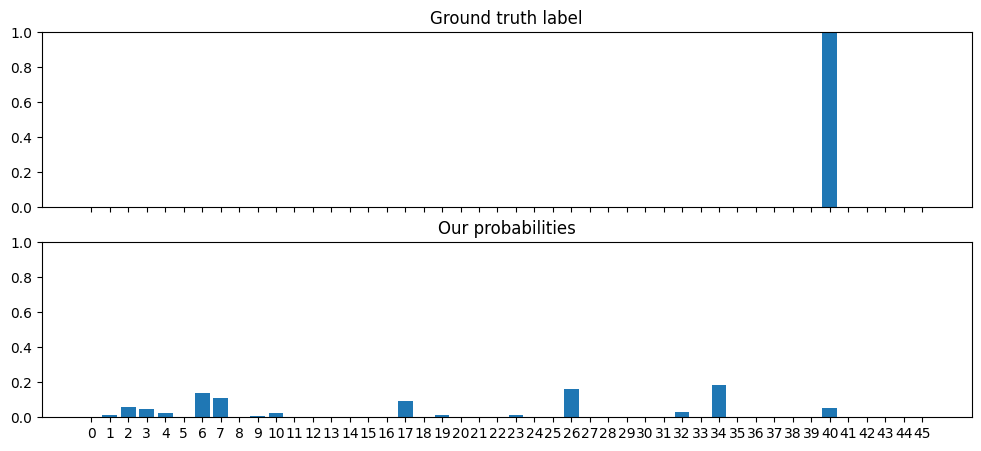

In [17]:
probs = tf.nn.softmax(nums)
random_label = np.zeros(probs.shape)                             # a random label with 1 at the index of the correct class
random_label[np.random.randint(0,random_label.shape[0])] = 1

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12,5))
ax1.bar([str(x) for x in range(nums.shape[0])], random_label)   # our ten numbers
ax1.set_title("Ground truth label")
ax1.set_ylim([0,1])
ax2.bar([str(x) for x in range(probs.shape[0])], probs) # plot the probabilities
ax2.set_title("Our probabilities")
ax2.set_ylim([0,1])
plt.show()

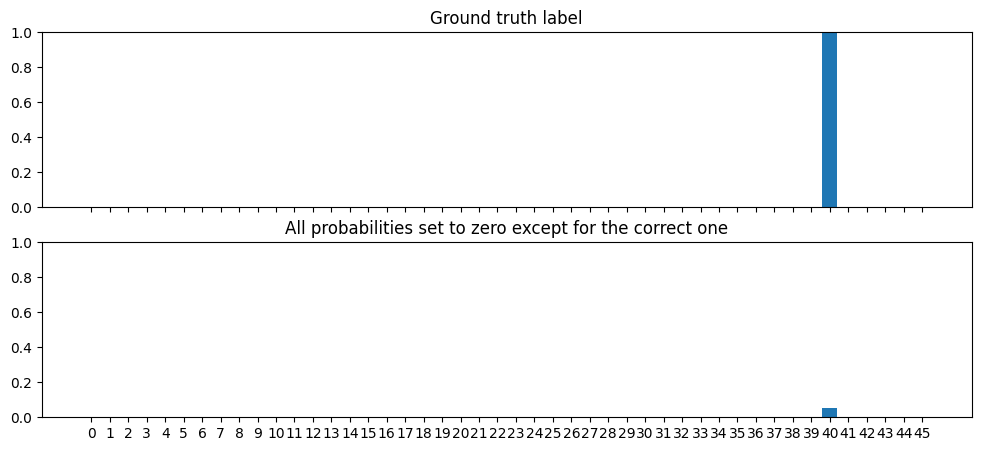

In [18]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12,5))
ax1.bar([str(x) for x in range(nums.shape[0])], random_label)   # our ten numbers
ax1.set_title("Ground truth label")
ax1.set_ylim([0,1])
ax2.bar([str(x) for x in range(probs.shape[0])], probs * random_label) # plot the probabilities
ax2.set_title("All probabilities set to zero except for the correct one")
ax2.set_ylim([0,1])
plt.show()

### Code: build the model

In [28]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input((10000,)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(46, activation='softmax')) # ← ACTIVATION & as many units as we have classes!

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 46)             │         2,990 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 647,214 (2.47 MB)

 Trainable params: 647,214 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

#### Note: calculating the number of parameters

$$
\bbox[5px,border:2px solid red]
{
\mathrm{number\ of\ params\ per\ layer} = \underbrace{\mathrm{input\ dim} \times \mathrm{number\ of\ units}}_{\mathrm{weights\ matrix}}
+
\underbrace{\mathrm{number\ of\ units}}_{\mathrm{bias\ vector}}
}
$$

In [20]:
# The weight and bias tensors
def print_layer_tensor_shape(layer):
    weight_params, bias_params = model.layers[layer].get_weights()
    print(layer, "\t", weight_params.shape, "\t", bias_params.shape)

print("layer", "\t", "(in, units)", "\t", "bias")
print_layer_tensor_shape(layer=0)
print_layer_tensor_shape(layer=1)
print_layer_tensor_shape(layer=2)

layer 	 (in, units) 	 bias
0 	 (10000, 64) 	 (64,)
1 	 (64, 64) 	 (64,)
2 	 (64, 46) 	 (46,)


In [21]:
print(f"{(10000 * 64 + 64) + (64 * 64 + 64) + (64 * 46 + 46):,}") # same as above

647,214


### Code: compilation

In [29]:
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy', # one label out of multiple choices
    metrics=['accuracy']
)

## Before training: commonsense baseline / evaluate untrained model

### Random baseline

What would be a **random baseline**?

We assume all our classes have the same probability of happening, which, in our case, means that **there are the same amount of samples per class in our dataset**:

$$
\bbox[5px,border:2px solid red] {
p_{class} = \frac{1}{n\_classes}
}
$$

In [87]:
print("A random baseline (assuming a balanced dataset with 46 classes) is:", 1/46)

A random baseline (assuming a balanced dataset with 46 classes) is: 0.021739130434782608


#### Sanity checks

In [11]:
attempts = []
for test in test_labels: # ↓ a random number between 0 and 45
    attempts.append(np.random.randint(46) == test)
print(np.mean(attempts))

0.022707034728406055


In [12]:
# This was just one random run... Why not try this many times over?
many_attempts = []
n = 1000
for i in range(n):
    clear_output(wait=True)
    print(f"{i+1}/{n}")
    attempts = []
    for test in test_labels:
        attempts.append(np.random.randint(46) == test)
    many_attempts.append(np.mean(attempts))
print(np.mean(many_attempts))

1000/1000
0.02160106856634016


### 'Neural' baseline: our untrained model

Most randomly initialized models will perform worse than this...

In [31]:
results = model.evaluate(x_test, one_hot_test_labels, verbose=0) # our untrained model
print(f"test loss: {results[0]}, test accuracy: {results[1]}")

test loss: 3.8405895233154297, test accuracy: 0.014247551560401917


#### Want more precision? Random runs...

In [90]:
# Again, just one random run... You could be obsessive and try this many times...

if True: # change to True to run
    attempts = []
    n = 10 # could be more
    for i in range(n):
        clear_output(wait=True)
        print(f"{i+1}/{n}")
        tf.keras.backend.clear_session()
        dummy_model = tf.keras.models.Sequential()
        dummy_model.add(tf.keras.Input((10000,)))
        dummy_model.add(tf.keras.layers.Dense(64, activation='relu'))
        dummy_model.add(tf.keras.layers.Dense(64, activation='relu'))
        dummy_model.add(tf.keras.layers.Dense(46, activation='softmax'))

        dummy_model.compile(
            optimizer='rmsprop',
            loss='categorical_crossentropy', # one label out of multiple choices
            metrics=['accuracy']
        )

        results = dummy_model.evaluate(x_test, one_hot_test_labels, verbose=0)
        attempts.append(results)

    results = np.array(attempts).mean(axis=0) # average along loss and accuracy respectively
    print()
    print(f"test loss: {results[0]}, test accuracy: {results[1]}")

10/10

test loss: 3.834512233734131, test accuracy: 0.02199465725570917


### Commonsense baseline for unbalanced datasets?

We use the probability of **the most frequent** class instead of a random guess.

Predicting the most common class in an unbalanced dataset **will do better** than a plain random guess...

Namely: "The most common class is X. Let's only predict X, and see how wrong we are (overall)."

*Take a coin toss: if you know that the coin is biased towards head, 80% of the time, you can just predict head only and expect to win 80%  of the time!*

In [20]:
totals = np.zeros(46)
for i in range(len(test_labels)): # counting how many examples we have
    totals[test_labels[i]] += 1   # of each class by looping and incrementing
indx = np.argmax(totals)

msg =  f"The most prevalent class is: {indx}, occurring {totals[indx]:.0f} times "
msg += f"(total: {test_labels.shape[0]}),  probability: {totals[indx]/test_labels.shape[0]:.6f}."
print(msg)                                               # ↑ number of occurrences / total

The most prevalent class is: 3, occurring 813 times (total: 2246),  probability: 0.361977.


In [93]:
# Note: we could also use a counter:
from collections import Counter
c = Counter(test_labels)
c.most_common(n=1)[0][0] # ← you could ask for the n most common items

3

In [88]:
# a plain loop will give us the same result
attempts = []
for test in test_labels: # only predict the most prevalent class
    attempts.append(indx == test)
print(f"The accuracy baseline to beat (if we predict the most prevalent class):", np.mean(attempts))

The accuracy baseline to beat (if we predict the most prevalent class): 0.3619768477292965


---

## 4.2.4 Validating your approach

### Code: train

In [32]:
# split into train and evaluation
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [33]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs = 20,
    batch_size = 512,
    validation_data = (x_val, y_val) # ← validation!
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.3398 - loss: 3.1143 - val_accuracy: 0.5980 - val_loss: 1.8411
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6498 - loss: 1.6286 - val_accuracy: 0.6810 - val_loss: 1.3847
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7346 - loss: 1.2140 - val_accuracy: 0.7340 - val_loss: 1.1983
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7862 - loss: 1.0096 - val_accuracy: 0.7800 - val_loss: 1.0710
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8258 - loss: 0.8167 - val_accuracy: 0.7860 - val_loss: 0.9983
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8537 - loss: 0.6855 - val_accuracy: 0.8000 - val_loss: 0.9578
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8787 - loss: 0.5705 - val_accuracy: 0.8170 - val_loss: 0.9002
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9012 - loss: 0.4711 - val_accuracy: 0.8110 - 

### Code: plot & automatic best epoch extraction

In [34]:
history.history.keys() # Training and validation loss and accuracy are saved in the history object

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [35]:
def plot_epochs(y_train, y_validation, title, y_label):
    x = range(1, len(y_train) + 1)
    plt.clf()
    plt.plot(x, y_train, "bo", label = "training")
    plt.plot(x, y_validation, "b", label = "validation")
    if y_label == "Loss":
        x_overfitting = np.argmin(y_validation)
        plt.text(x_overfitting + 1,
                 y_validation[x_overfitting] + y_validation[x_overfitting]/10,
                 f"↓ min: epoch {x_overfitting + 1}")
    elif y_label == "Accuracy":
        x_overfitting = np.argmax(y_validation)
        plt.text(x_overfitting + 1,
                 y_validation[x_overfitting] - y_validation[x_overfitting]/20,
                 f"↑ max: epoch {x_overfitting + 1}")
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel("Epochs")
    plt.xlim(xmin=0)
    plt.legend()
    plt.show()

In [36]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

In [37]:
print(f"Smallest val loss at epoch {np.argmin(val_loss) + 1}: {np.min(val_loss)}")

Smallest val loss at epoch 10: 0.857914924621582


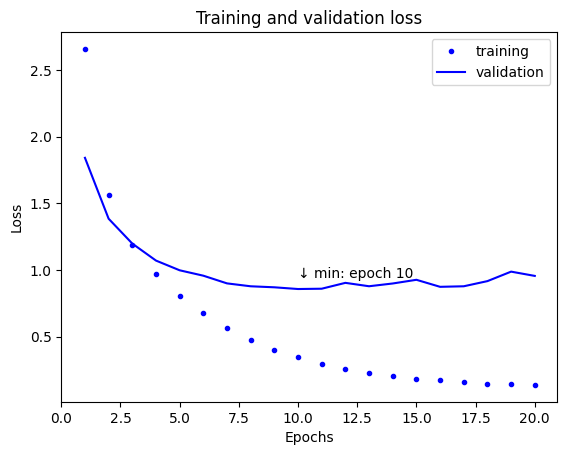

In [38]:
plot_epochs(
    loss, val_loss,
    title='Training and validation loss',
    y_label='Loss'
)

In [39]:
print(f"Higest val accuracy at epoch {np.argmax(val_acc) + 1}: {np.max(val_acc)}")

Higest val accuracy at epoch 11: 0.8270000219345093


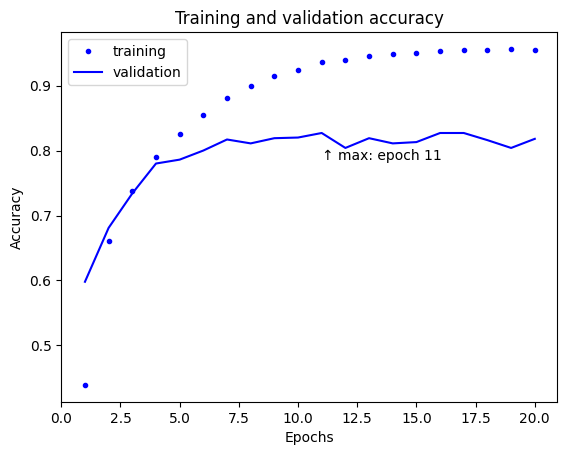

In [40]:
plot_epochs(
    acc, val_acc,
    title='Training and validation accuracy',
    y_label='Accuracy'
)

### Code: early stopping – retrain on whole training data up until the overfitting starts

In [41]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.keras.Input((10000,)))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(46, activation="softmax"))

model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history=model.fit(
    x_train,                        # ← retrain on whole train dataset
    one_hot_train_labels,
    epochs=np.argmax(val_acc) + 1,  # ← use the index of our maximum validation accuracy as max epoch
    batch_size=512
)

Epoch 1/11
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.4108 - loss: 3.1612
Epoch 2/11
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6637 - loss: 1.5857
Epoch 3/11
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7401 - loss: 1.1941
Epoch 4/11
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7945 - loss: 0.9464
Epoch 5/11
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8322 - loss: 0.7912
Epoch 6/11
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8569 - loss: 0.6561
Epoch 7/11
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8795 - loss: 0.5543
Epoch 8/11
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8991 - loss: 0.4739
Epoch 9/11
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9145 - loss: 0.4013
Epoch 10/11
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9271 - loss: 0.3323
Epoch 11/11
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9398 - loss: 0.2929


### Code: evaluate on the test set

In [42]:
results = model.evaluate(x_test, one_hot_test_labels, verbose=0)

print(f"test loss: {results[0]}, test accuracy: {results[1]}")

test loss: 0.9072009921073914, test accuracy: 0.7934104800224304


---

## 4.2.5 Generating prediction on new data

Let's get back to our trained model.

The predictions and labels for the first 10 wires in the test set.

In [43]:
predictions = model.predict(x_test, verbose=0)
print('wire', '\t', 'pred', '\t', 'label', '\t', 'correct?')
for i in range(10):
    print(i, '\t', np.argmax(predictions[i]), '\t', test_labels[i], '\t', np.argmax(predictions[i]) == test_labels[i])

wire 	 pred 	 label 	 correct?
0 	 3 	 3 	 True
1 	 10 	 10 	 True
2 	 1 	 1 	 True
3 	 16 	 4 	 False
4 	 13 	 4 	 False
5 	 3 	 3 	 True
6 	 3 	 3 	 True
7 	 3 	 3 	 True
8 	 3 	 3 	 True
9 	 3 	 3 	 True


It would be nice to have a more concrete idea of where our network got it wrong, wouldn't it?

In [44]:
def indices_of_wrong_predictions():
    indices = []
    for i in range(len(x_test)):
        y_pred = np.argmax(predictions[i])
        if(y_pred != test_labels[i]):
            indices.append(i)
    return indices

In [45]:
def misprediction(i):
    wrongs = indices_of_wrong_predictions()
    print(f"Wire n° {i}/{len(wrongs)}")
    try:
        oops = wrongs[i]
        pred = np.argmax(predictions[oops])
        print(f"predicted: {topics[pred]}, label: {topics[test_labels[oops]]}")
        print()
        print(decode_wire(test_data[oops]))
    except:
        print(f"Oops, your index was {i} and the max is {len(wrongs)}")

In [46]:
misprediction(1) # the second mistaken prediction...

Wire n° 1/464
predicted: ship, label: acq

? strong south ? winds were keeping many vessels trapped in the ice off the finnish and swedish coasts in one of the worst icy periods in the baltic for many years the finnish board of navigation said in finland and sweden up to 50 vessels were reported to be stuck in the ice and even the largest of the ? ? were having difficulties in breaking through to the ? ships ? officials said however icy conditions in the southern baltic at the soviet oil ports of ? and ? had eased they said weather officials in neighbouring sweden said the icy conditions in the baltic were the worst for 30 years with ships fighting a losing battle to keep moving in the coastal stretches of the gulf of ? which ? finland and sweden the ice is up to one ? thick with ? and ? packing it into almost ? walls three metres high swedish ? officials said weather forecasts say winds may ease during the weekend but a further drop in temperature could bring shipping to a standstill 

In [47]:
misprediction(11) # and another one...

Wire n° 11/464
predicted: earn, label: gnp

? the japanese economy has bottomed out after an extended period of ? finance minister kiichi miyazawa told a press conference but he said he was not too optimistic about the state of the economy as the employment situation was still ? in certain regions of the country yesterday the finance ministry said its quarterly corporate survey showed that the economy was showing increasing signs of recovery reuter 3


---

## 4.2.6 A different way to handle the labels and the loss

One-hot encoding takes a lot of memory, and is very sparse (zeros everywhere).

Instead of that, we could cast the labels as integer tensors, simply storing the right index.

In [48]:
y_train_sparse = np.array(train_labels) # cast as int
y_test_sparse = np.array(test_labels)
print(y_train_sparse[:10], y_train_sparse.dtype)

[ 3  4  3  4  4  4  4  3  3 16] int64


Everything else remains the same, except for the choice of loss function.

Use `sparse_categorical_crossentropy` with integer labels: instead of a one-hot vector with the label at index i, you just provide i as an integer.

**Sparse** refers to the fact that we encode the same amount of information as a big matrix full of zeros (one-hot) into a vector of integers, much more compact!

(Actually, the new loss function is the same as `categorical_crossentropy` – the programming interface has changed, that's all).

In [49]:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential()
model.add(tf.keras.Input((10000,)))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(46, activation="softmax"))

model.compile(
    optimizer='rmsprop',
        # ↓ instead of 'categorical_crossentropy'
    loss='sparse_categorical_crossentropy',
        # ↑ -------------------------------------
    metrics=['acc']
)

In [50]:
history = model.fit(
    x_train,         # the same x_train as before
    y_train_sparse,  # integers instead of one-hot vectors
    epochs=np.argmin(val_loss) + 1,
    batch_size=512,
)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - acc: 0.4177 - loss: 3.1719
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.6771 - loss: 1.5353
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.7582 - loss: 1.1318
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8029 - loss: 0.9204
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - acc: 0.8336 - loss: 0.7802
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8655 - loss: 0.6321
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8901 - loss: 0.5073
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9061 - loss: 0.4391
Epoch 9/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9240 - loss: 0.3649
Epoch 10/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - acc: 0.9331 - loss: 0.3001


In [51]:
results = model.evaluate(x_test, y_test_sparse)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - acc: 0.7991 - loss: 0.9060


---

## 4.2.7 The importance of having sufficiently large intermediate layers

## (+ Modular programming!)

The final layer has 46 units.

Intermediate layers of fewer than 46 units might cause an information bottleneck.

Explore the consequence of a very small intermediate representation – just 4D.

### Code: modular programming – a build function

A network building function for decluttering notebooks and ease of experimentation. The size of each layer – number of units – is passed as function arguments.

In [52]:
def build(layer_1, layer_2, layer_3, clear=True):
    if clear: # by default, I clear the memory of previous models
        tf.keras.backend.clear_session()
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input((10000,)))
    model.add(tf.keras.layers.Dense(layer_1, activation='relu'))    # ← IDEA FOR COURSEWORK: rewrite this
    model.add(tf.keras.layers.Dense(layer_2, activation='relu'))    # as a loop allowing you to build
    model.add(tf.keras.layers.Dense(layer_3, activation='softmax')) # models with variable depths straight
    model.compile(                                                  # from the function's arguments...
        optimizer='rmsprop',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

### Code: modular programming – a train function

A training function. This function could be modified to include training hyperparameters as function parameters.

In [53]:
def train(model):
    # we train and return the history!
    return model.fit(
        partial_x_train,
        partial_y_train,
        epochs=20,
        batch_size=512,
        validation_data=(x_val, y_val),
        verbose=0
    )

### Code: automated model building and training

In [54]:
model = build(layer_1=64, layer_2=64, layer_3=46) # our original Reuters network
history = train(model)
ind = np.argmax(history.history['val_accuracy'])
print(f"max val accuracy: {history.history['val_accuracy'][ind]} at epoch {ind}")

max val accuracy: 0.8259999752044678 at epoch 16


In [55]:
model = build(layer_1=64, layer_2=4, layer_3=46) # creating a bottleneck in the second layer
history = train(model)
ind = np.argmax(history.history['val_accuracy'])
print(f"max val accuracy: {history.history['val_accuracy'][ind]} at epoch {ind}")

max val accuracy: 0.6909999847412109 at epoch 14


---

## 4.2.8 Further experiments

## 4.2.9 Wrapping up

### Workflow

1. Prepare the data & split into Train/Validation/Test
2. Define your model
4. Evaluate your untrained model / a **commonsense baseline**
5. Train using **Train/Validation**
6. Tweak **hyperparameters** → pick best validation results
7. Retrain on **whole train dataset**
8. Evaluate on **Test**

### Summary

#### Inputs

- Processing inputs as *multi-hot*;

#### Labels

- Labels as *one-hot* vectors with the `categorical_crossentropy`;
- Labels as *integers* with the `sparse_categorical_crossentropy`;

#### Key ideas

- Train/Validation/Test splits;
- Overfitting;
- Commonsense baselines;
- Information bottlenecks (small intermediate layers)!

### Single-label multi-class classification

- The output layer for a multi-classification task should have **as many units as there are classes**;
- Use a **softmax** activation function;
- The loss function is `categorical_crossentropy` or `sparse_categorical_crossentropy`;
- A softmax layer outputs a **probability distribution** over possible classes;

### Experiments

- More or fewer hidden layers, with less/more units;
- Try different learning rates and batch sizes;
- Replace `relu` with an early neural network favourite, `tanh`;
- Try the [`Adam` optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers#classes_2): `optimizers.Adam(learning_rate=0.001)`, with various learning rates.
- Try and think about how you would go about automating hyperparameter search (= making your life easier, so that the search is done by a system rather than manually)

---

### Extra: Multi-label multi-class classification

What about *multi-label multi-class classification*?

Namely, more than one label are possible?

(Not in the Chollet. [Here is an example in Keras](https://keras.io/examples/nlp/multi_label_classification/)).

#### Workflow 

- make your labels **multi-hot**;
- output activation is `sigmoid`;
- track accuracy with `categorical_accuracy`;
- select the top $k$ highest probabilities when using the model (typically using `np.argsort`).

Keras knows that if you give it multi-hot labels and select `binary_crossentropy`, it means that **each class is treated as an independent probability**.

### Types of Problems: Summary table 


<!-- ![correct last layers activations](images/chollet/correct-last-layer-activations.png) -->
<img src="https://raw.githubusercontent.com/jchwenger/AI/main/3-getting-started/images/chollet/correct-last-layer-activations.png">

<small>DLWP, _second edition_, p.164</small>